<div class="alert alert-info">
- To start the presentation, click this button in the toolbar: <img src="./images/presentation_start_button.png" width="32.5" height="24.5">  
- You can zoom in and out on a slide with your browser's zoom function to see all content.
</div>

# Predicting the Wind: Data Science in Wind Resource Assessment
**– Self-study version –**

**[Florian Roscheck](https://www.linkedin.com/in/florianroscheck/), Data Scientist**

2020-03-11, [PyData San Diego Meetup](https://www.meetup.com/PyData-San-Diego/)

<br>
Source Code:

<img src="./images/qr_code_github.png" style="width: 8em">

[github.com/flrs/predicting_the_wind](https://github.com/flrs/predicting_the_wind)

**Intended audience:** Data analysts and data scientists who are interested in learning about how data science techniques are applied in the wind energy domain.

## Agenda

- What is wind resource assessment?
- How to measure the wind
- Predicting long-term wind speeds
- Predicting wind turbine power output

## What is Wind Resource Assessment?

<img src="./images/sandbox_you_are_here.jpg" style="width: 35em">

<img src="./images/sandbox_build_this_wind_farm.jpg" style="width: 40em">

<span style="font-size:250%">🤔</span>

**Sounds good, but...**

- How much power is in the wind? 

- Will you be able to sell the generated electricity at a profit?

- A profit over the *next 25 years*?

<span style="font-size:250%">💡</span>

**Wind resource assessment to the rescue!**

- Predict long-term behavior of the wind

- Predict power output of wind turbines

- Know if you will make a profit!

## Wind Resource Assessment = ❤️

- Building models of the physical world is exciting
- Uncertainty is not just a footnote
- Modern data science is relatively new in the field
- Reduce emissions and slow global warming!

## Predicting the Wind: A Data Science Problem!

- Getting wind data
- Cleaning wind data
- Analyzing wind data
- Building a model of the wind
- Predicting the wind and output of the wind farm

This is a typical data science workflow!

## Getting Wind Data: Met Masts

- Met masts look like this:
<img src="./images/met_mast.jpg" style="height: 16em">
- Measure the wind at different heights

- Have sensors for wind speed, wind direction, temperature, humidity, and precipitation

## Analyzing Wind Data

Let's load data from a met mast and check it out!

In [1]:
import pandas as pd

data = pd.read_parquet('./data/met_mast.parquet')

data.round(2).head()

,spd_30,spd_45,spd_58,tmp,dir
time,,,,,
1999-12-31 16:00:00,3.39,3.73,3.84,12.37,243.68
1999-12-31 16:10:00,3.27,3.65,3.81,12.22,250.02
1999-12-31 16:20:00,3.31,3.63,3.80,12.12,252.29
1999-12-31 16:30:00,3.78,4.26,4.38,12.04,249.54
1999-12-31 16:40:00,3.96,4.38,4.52,11.99,254.50


Our met mast data show wind speed in m/s at 30, 45, and 58 m height, temperature in °C, and wind direction in °, in 10-minute intervals.

(These data are all artifical and I generated them in [this notebook](./data_acquisition/synthesizing_a_wind_speed_time_series.ipynb).)

In [2]:
# Let's assume we only have 2 years of met mast data
data = data['2018-02-01':]

Let's get a feel for the wind data by plotting them!

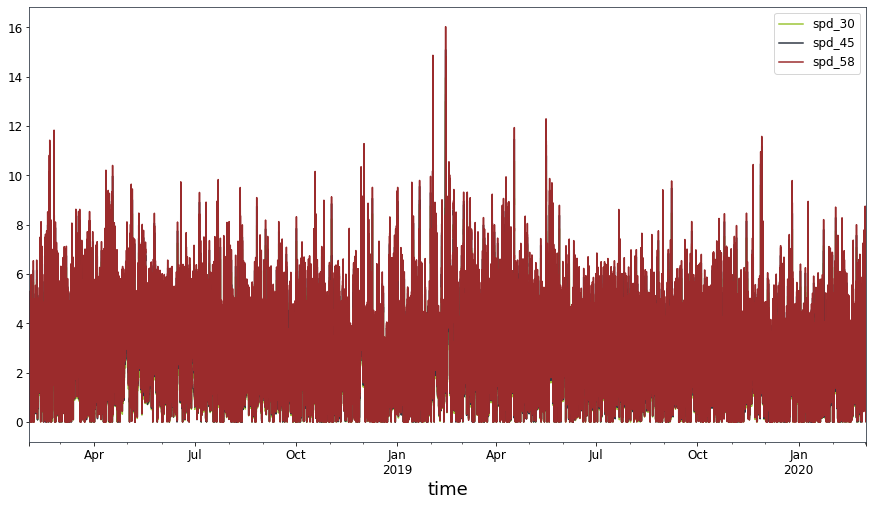

In [3]:
# Plot wind speed time series

import brightwind as bw

anemometers = ['spd_30','spd_45', 'spd_58']
bw.plot_timeseries(data[anemometers])

...wow, that looks very messy!

Let's plot a single day to see more detail!

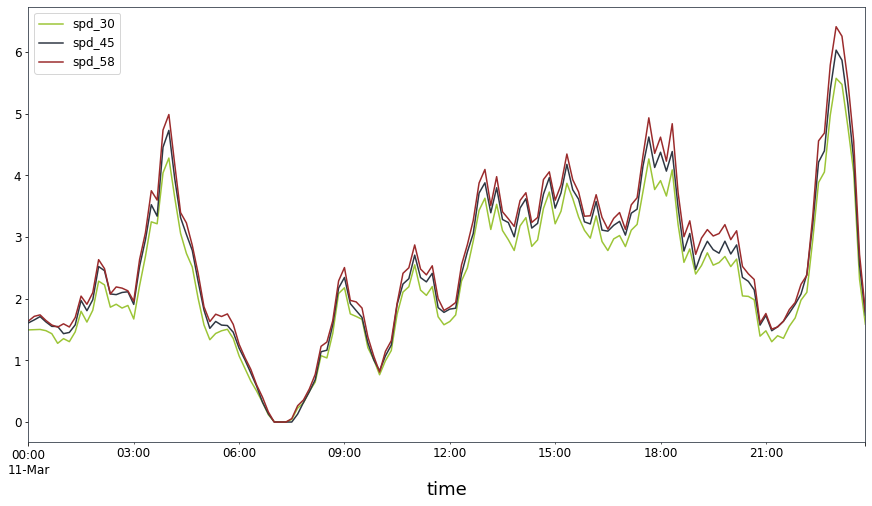

In [4]:
bw.plot_timeseries(data.loc['2019-03-11',anemometers])

Observations: Wind speed varies a lot throughout the day. Higher height means higher wind speed.

Which direction does the wind come from? Let's plot a frequency rose 🌹!

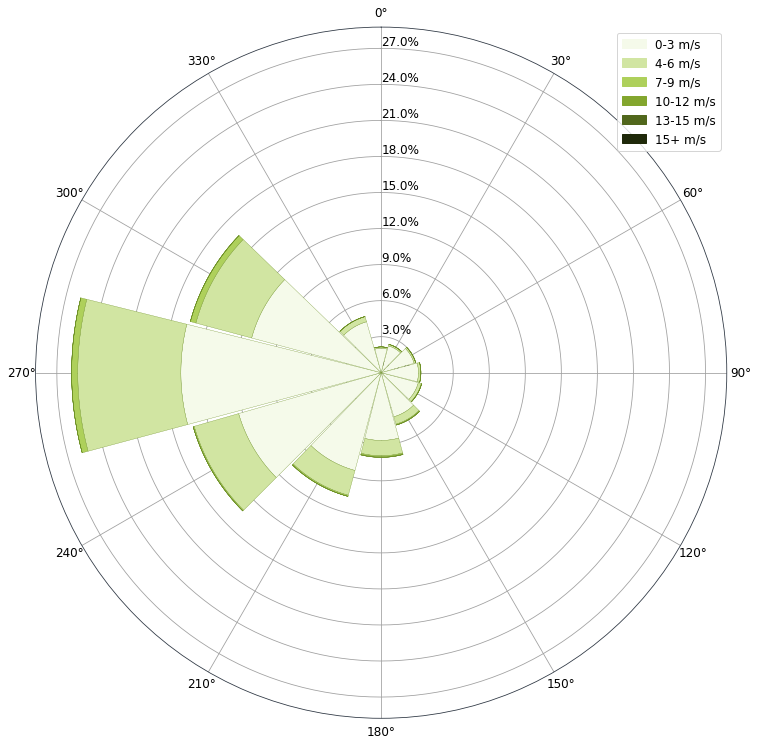

In [5]:
bw.freq_table(data['spd_30'], data['dir'])

**Wind Data Analysis Takeaways**

- Wind data = long time series
- Wind data looks messy
- There are domain-specific tools to structure and explore wind data (e.g. frequency roses)

## From Measurement to Prediction: Building a Model

We want to predict how much energy a wind farm will likely produce in 25 years of operation.

- **Problem**: 
 - Only 2 years of met mast wind measurements to predict 25 years of wind
 - With that little data we really don't know enough about how the wind will behave!

- **Solution**: 
  - Get more, longer-term data from other sources, covering as much time as possible

- **Rationale**:
    - The more we know about the past, the better we can predict the future.

### Section Overview

- How and where to get more long-term data
- Build a simple model to predict wind speeds
- Use a more advanced model from scikit-learn to predict wind speeds
- Improve models with wind energy domain knowledge
- Investigate how to score and compare wind speed models

### Getting More, Long-Term Data

Popular data sources: Global climate models, measurements by third parties

<img src="./images/long_term_reference_map.png" style="height: 16em">

Close to the Sandbox (blue): 4 climate model grid points (orange), 3 airport measurement stations (purple)

Let's load climate model ([ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)) and airport station data!

In [6]:
from pathlib import Path
import pandas as pd

lt_data = {'era5_0': 'era5_0.parquet',
           'era5_1': 'era5_1.parquet',
           'MYF': 'MYF_200001010000_202003070000.parquet',
            'NKX': 'NKX_200001010000_202003070000.parquet',
            'SAN': 'SAN_200001010000_202003070000.parquet'}

for name, file in lt_data.items():
    lt_data[name] = pd.read_parquet(Path('./data/').joinpath(file))
    
lt_data['era5_0'].head()

,spd,dir,tmp
time,,,
1999-12-31 16:00:00,4.548827,249.010856,12.370013
1999-12-31 17:00:00,3.981960,251.738388,11.915547
1999-12-31 18:00:00,2.607753,249.791620,11.245783
1999-12-31 19:00:00,1.559933,233.880179,9.782310
1999-12-31 20:00:00,1.359054,231.334928,10.454369


Climate models typically do not output wind speed at ground level and only have 1-hr resolution.

([This notebook](./data_acquisition/downloading_ERA5_data_in_python.ipynb) shows how I downloaded ERA5 data and [this notebook](./data_acquisition/download_and_preprocess_asos_data.ipynb) shows how I downloaded airport station data.)

### From Short-Term to Long-Term Data 

Our challenges:
- Airport measurements are taken and climate models are calculated far from our site (the Sandbox).
- They have measurements in greater intervals than our met mast.

How much can we trust them to tell us about the wind characteristics at the Sandbox?

Let's plot met mast wind speed data against the data from the ERA5 climate model!

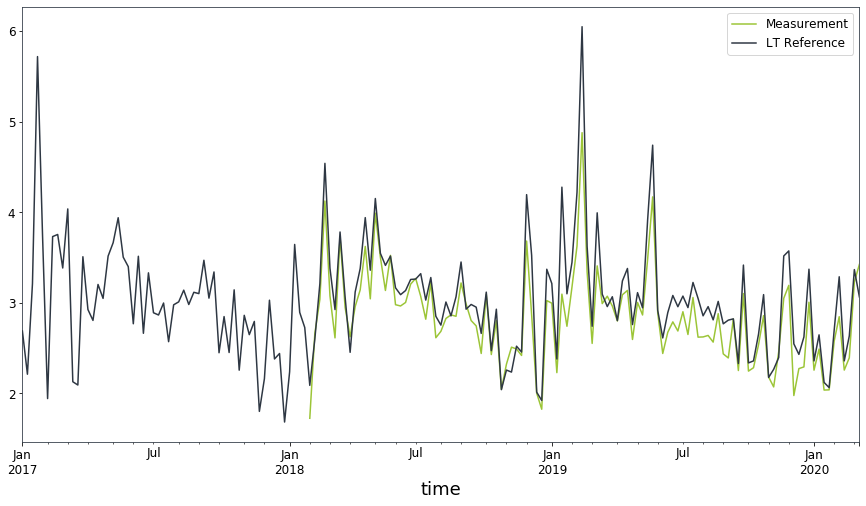

In [7]:
plot_data = pd.concat([data['spd_58'].resample('1W').mean(), lt_data['era5_0']['spd'].resample('1W').mean()], axis=1)
plot_data.columns = ['Measurement', 'LT Reference']

bw.plot_timeseries(plot_data, date_from='2017')

Good news: Despite being physically far away, there seem to be great similarities between the climate model and the met mast data. (This is not always the case, but it is here to make this tutorial fun and easy.)

**Problem**: How do we exploit the similarities between references and met mast data to get an idea of what our met mast data would have looked like if we had measured for 25 years?

**Solution**: 
1. Build model describing relationship between measurement and references
2. Let model predict what long-term measurement would look like

Let's build a model!

### A Simple Model: Orthogonal Least Squares

Orthogonal least squares: Draw a best-fit line between all timestamp-points of reference and met mast wind speed that minimizes the orthogonal distance between line and timestamp-point

In [8]:
from brightwind.analyse.correlation import OrthogonalLeastSquares

# Resample to daily
data_1D = data.resample('1D').mean()
lt_data_1D = lt_data['era5_0'].resample('1D').mean()

ols_model = OrthogonalLeastSquares(ref_spd=lt_data_1D['spd'], 
                                   target_spd=data_1D['spd_58'], 
                                   averaging_prd='1D')
ols_model.run()

{'Num data points': 761,
 'offset': 0.48915546304725566,
 'r2': 0.8682745042710436,
 'slope': 0.7728460999482368}


It looks like we have a good amount of data (7k+ points) and a respectable $R^2$ of 0.89. Let's plot our line of best fit!

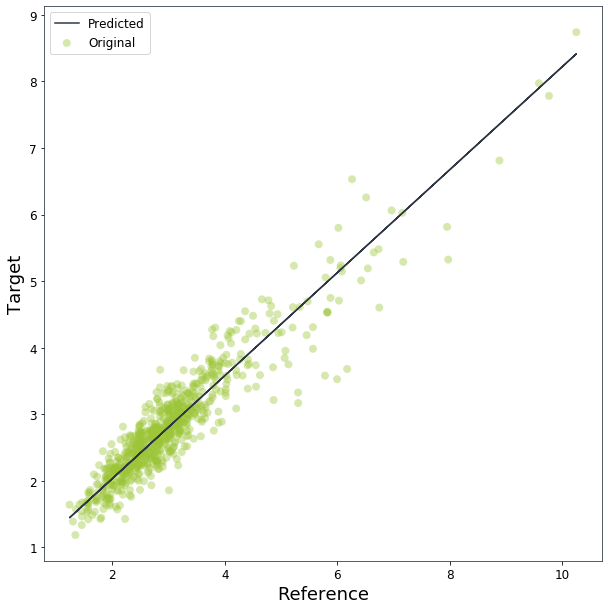

In [9]:
ols_model.plot()

There is some scatter but model fits the data quite well. 

**Problem**:
- To make sense of the model in terms of how well it can predict wind speeds, we want to use it to predict the wind speeds for the time period when we have met mast measurements and then compare these measurements to the model's predictions.
- For this purpose, $R^2$ as error metric is inappropriate - it tells us nothing about wind speeds!
- (Interpretation of $R^2$ is also rather tricky for orthogonal least squares regression in general)

**Solution**:

Use RMSE (root mean square error) of predicted wind speed vs. actual measured wind speed as error metric!

In [10]:
# Define scoring metric: RMSE

import numpy as np

def rmse(prediction, actual):
    return np.sqrt(((prediction-actual)**2).mean())

all_predictions = {}
all_scores = {}

Let's score the simple orthogonal least squares model using RMSE!

In [11]:
prediction = (ols_model.params['slope']*lt_data_1D['spd']+ols_model.params['offset'])

all_predictions['simple'] = prediction
all_scores['simple'] = rmse(prediction, data_1D['spd_58'])

print('RMSE of simple model: {:.3f}'.format(all_scores['simple']))
print('RMSE as % of wind speed mean: {:.0f}%'.format(all_scores['simple']/data_1D['spd_58'].mean()*100))

RMSE of simple model: 0.315
RMSE as % of wind speed mean: 11%


The RMSE is 11% of the wind speed. This is not really a good number. If we would build the project assuming 11% faster winds than we would actually have, we would have made a very expensive mistake.

So: How can we improve the model?

Let's learn about Physics! 

- Also: How do measurements at the met mast relate to measurements at turbine heights?
- Modeling challenges: Topography

### Topography vs. Wind

<img src="./images/shear_over_hill.gif" style="height: 15em">

- Imagine a wind gust enters picture on left as a vertical line.
- As gust moves over a hill from left to right, it accelerates towards the top and decelerates towards the bottom (vertical line becomes diagonal).
- Position of hills relative to our site may influence expected wind speeds.

**Elevation Map of Area Around the Sandbox**

<img src="./images/sandbox_elevation_map.png" style="height: 20em">

We ommitted the scale, but it looks as if there are some elevation differences around the Sandbox.

**How can we take advantage of the topographic information?**

Let's try building models for different wind directions!

Rationale: We may find that there is more similarity in wind speeds between mast and reference in some directions than in others.

### A Better Model: Binned Orthogonal Least Squares

Our simple model – just binned in 12 direction sectors.

Quick remark: We use [SciPy](https://www.scipy.org/) for building our model here instead of [Brightwind](https://github.com/brightwind-dev/brightwind), since I want to show you that you can even analyze wind data with more common data science tools.

In [12]:
# Bin data by direction

dir_bins = pd.IntervalIndex.from_breaks(np.linspace(0,360,13))

data_1D = data.resample('1D').mean()
lt_data_1D = lt_data['era5_0'].resample('1D').mean()

lt_data_1D['dir_bin'] = pd.cut(lt_data_1D['dir'], dir_bins)
data_1D['dir_bin'] = pd.cut(data_1D['dir'], dir_bins)

In [13]:
# Build binned orthogonal least squares model

from scipy.odr import ODR, Model, Data

def get_data_in_dir_bin(dir_bin):
    lt_data_in_bin = lt_data_1D['spd'][lt_data_1D['dir_bin'] == dir_bin]
    data_in_bin = data_1D['spd_58'][data_1D['dir_bin'] == dir_bin]
    return lt_data_in_bin, data_in_bin

def model_fcn(B, x):
    return B[0]*x+B[1]

bin_stats = {}
for bin_nx, dir_bin in enumerate(dir_bins):
    bin_stats[bin_nx] = {'n_samples': None, 'betas': None, 'rmse': np.nan, 'predictions': None}
    lt_data_in_bin, data_in_bin = get_data_in_dir_bin(dir_bin)
    
    concurrent_nxs = list(set(lt_data_in_bin.index).intersection(set(data_in_bin.index)))
    bin_stats[bin_nx]['n_samples'] = len(concurrent_nxs)
    
    if not concurrent_nxs:
        continue
    
    result = ODR(Data(lt_data_in_bin[concurrent_nxs].values, data_in_bin[concurrent_nxs].values), Model(model_fcn),
                beta0=[1., 0.5]).run()

    bin_stats[bin_nx]['predictions'] = model_fcn(result.beta, lt_data_in_bin)
    bin_stats[bin_nx]['betas'] = result.beta
    bin_stats[bin_nx]['rmse'] = rmse(bin_stats[bin_nx]['predictions'], data_in_bin)

all_predictions['binned'] = pd.concat([bin_stat['predictions'] for bin_stat in bin_stats.values()\
                                       if bin_stat['predictions'] is not None]).sort_index()
all_scores['binned'] = np.nanmean([bin_stat['rmse'] for bin_stat in bin_stats.values()])

print('RMSE of binned model: {:.3f}'.format(all_scores['binned']))

RMSE of binned model: 0.289


**Scores so far**

- RMSE of simple model: 0.315
- RMSE of binned model: 0.289
- Our binned model performs better already!

### A More Advanced Model: RandomForestRegressor

**Expectation:** Random forest regressor captures nuances in relationship between reference and measurement better than other models

**Background:** A [random forest](https://medium.com/@williamkoehrsen/random-forest-simple-explanation-377895a60d2d) generates an estimate from multiple decision trees. Each tree only gets trained on a subset of samples and features. This means that each tree has some "specialized" knowledge about the data and can see a particular aspect of the data better than other trees. By combining the predictions of all trees, a random forest can provide a relatively robust prediction.

**Approach:**
- Engineer features that model can pick up on
- Run the model

**Feature Engineering**

Let's come up with some (simple) features that the random forest can feed on.

In [14]:
y = data_1D['spd_58']

# Get concurrent time steps
conc_index = sorted(list(set(y.index).intersection(lt_data_1D.index)))

X = lt_data_1D.loc[conc_index,['spd', 'dir', 'tmp']].sort_index()

# Rolling means
def make_rolling(data, window_width):
    rolling = data['spd'].rolling(window_width).mean()
    rolling = rolling.fillna(rolling.mean())
    rolling.name = 'spd_rolling_{}'.format(window_width)
    return pd.concat([data, rolling], axis=1)
X = make_rolling(X, 3)
X = make_rolling(X, 5)

# Date-based features to capture temporal patterns
X.loc[conc_index,'d'] = X.index.day
X.loc[conc_index,'m'] = X.index.month

X.head(3)

,spd,dir,tmp,spd_rolling_3,spd_rolling_5,d,m
time,,,,,,,
2018-02-01,1.455543,173.896001,15.397280,3.040377,3.040787,1.0,2.0
2018-02-02,1.528880,168.001625,16.170596,3.040377,3.040787,2.0,2.0
2018-02-03,2.025680,251.970139,16.567941,1.670035,3.040787,3.0,2.0


Now that we have data with features, let's build 2 models: One model for which we will withhold some validation data and, for comparison with the previous models, one model that uses all data.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=100, min_samples_leaf=10)
rf_model.fit(X_train, y_train)

print('RMSE (RF model, training set): {:.3f}'.format(rmse(rf_model.predict(X_train), y_train)))
print('RMSE (RF model, validation set): {:.3f}'.format(rmse(rf_model.predict(X_val), y_val)))

model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=100, min_samples_leaf=10)
model.fit(X, y)

predictions = model.predict(X)
all_predictions['forest'] = pd.Series(predictions,index=conc_index).sort_index()
all_scores['forest'] = rmse(predictions, y)

print('RMSE (RF model, all data): {:.3f}'.format(all_scores['forest']))

RMSE (RF model, training set): 0.303
RMSE (RF model, validation set): 0.330
RMSE (RF model, all data): 0.300


The RMSE is not too high and definitely within the range of the other models. Let's compare the models in more detail.

### Comparing the 3 Wind Speed Models

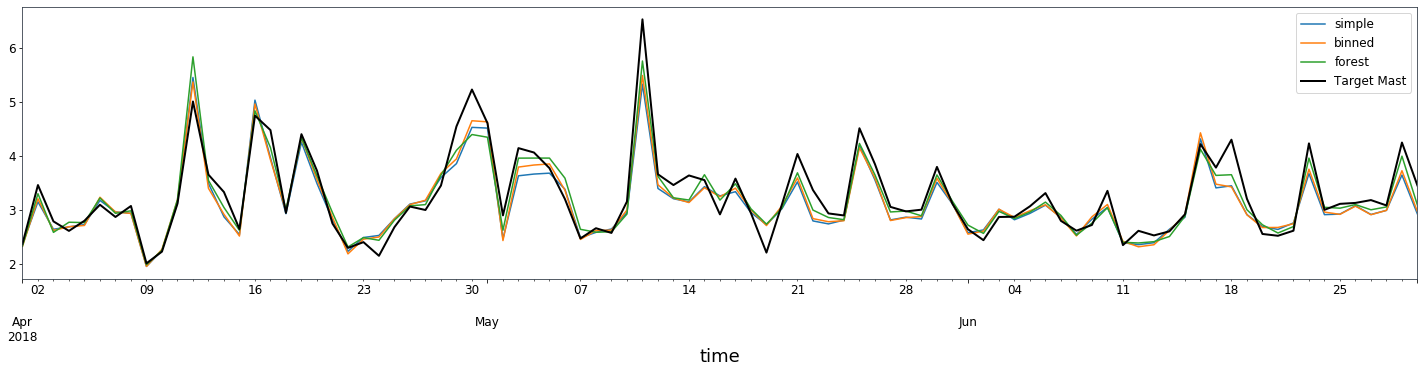

In [16]:
from matplotlib import pyplot as plt

pd.DataFrame(all_predictions).loc['2018-04':'2018-06',:].plot(figsize=(25,5))
data_1D['spd_58'].loc['2018-04':'2018-06'].plot(c='k',lw=2, label='Target Mast')

plt.legend()
plt.show()

All 3 models follow the target mast nicely. The forest model sometimes captures peaks better than other models (Jun 18, May 6), but also occasionally has bigger misses (Apr 12, May 30).

Time for a direct score comparison! Remember: The lower the RMSE, the better the model.

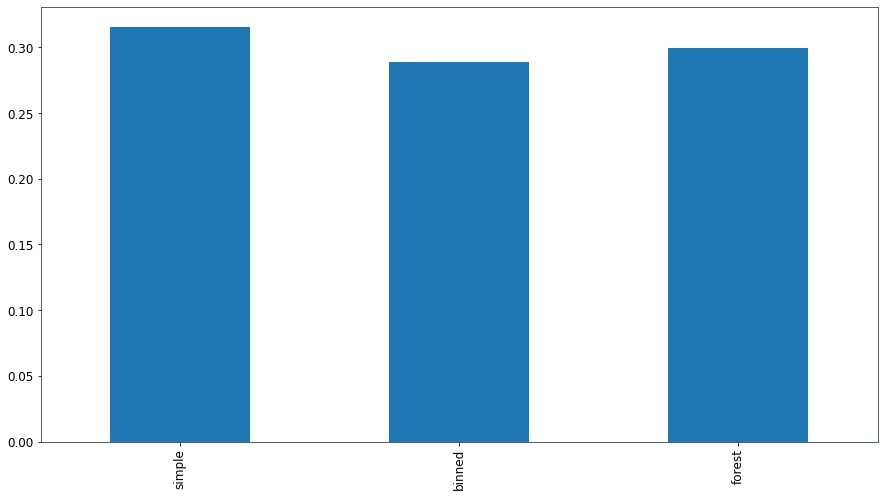

In [17]:
pd.Series(all_scores).plot.bar();

Despite all the fanciness of the random forest model, it does not reach the score of our binned model. This being said – an RMSE of 0.3 is still relatively high when measured in terms of wind speed.

<div class="alert alert-info">
Below: Additional content not shown in the original presentation.
</div>

### An In-Depth Look at the Binned Model

When we built the binned model, we did not spend any time inspecting it. Let's do that now. We want to understand how robust our model is. First, let's display the number of samples our model used per bin.

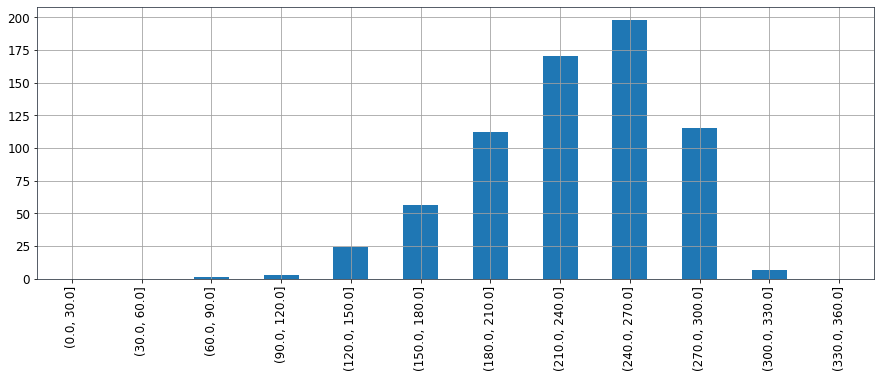

In [18]:
bin_wise_params = pd.Series([stat['n_samples'] for stat in bin_stats.values()], index=dir_bins)
bin_wise_params.plot.bar(figsize=(15,5))
plt.grid()

6 bins have under 25 samples. For predictions in these bins, the model is probably not very reliable.

It would be better to use our simple model for these cases, since we know that it has been trained on a lot of data and performs reasonably well.

In [19]:
betas = []

for beta, valid_binned, bin_ in zip([stat['betas'] for stat in bin_stats.values()], 
                              [stat['n_samples']>=25 for stat in bin_stats.values()],
                                   dir_bins):
    if not valid_binned:
        betas.append(np.asarray([ols_model.params['slope'], ols_model.params['offset']]))
        print('{}: Simple model'.format(bin_))
    else:
        betas.append(beta) 
        print('{}: Bin-wise model'.format(bin_))

(0.0, 30.0]: Simple model
(30.0, 60.0]: Simple model
(60.0, 90.0]: Simple model
(90.0, 120.0]: Simple model
(120.0, 150.0]: Simple model
(150.0, 180.0]: Bin-wise model
(180.0, 210.0]: Bin-wise model
(210.0, 240.0]: Bin-wise model
(240.0, 270.0]: Bin-wise model
(270.0, 300.0]: Bin-wise model
(300.0, 330.0]: Simple model
(330.0, 360.0]: Simple model


Now that we have a more robust model, let's re-predict our time series and check our RMSE metric!

In [20]:
bin_rmses = []
bin_predictions = []
for dir_bin, beta in zip(dir_bins, betas):
    lt_data_in_bin = lt_data_1D['spd'][lt_data_1D['dir_bin'] == dir_bin]
    data_in_bin = data_1D['spd_58'][lt_data_1D['dir_bin'] == dir_bin]
    
    bin_prediction = model_fcn(beta, lt_data_in_bin)
    bin_predictions.append(bin_prediction)
    
    bin_rmse = rmse(bin_prediction, data_in_bin)
    bin_rmses.append(bin_rmse)

all_predictions['binned_fill_simple'] = pd.concat(bin_predictions).sort_index()
all_scores['binned_fill_simple'] = np.nanmean(bin_rmses)

print('RMSE of binned with fill-in from simple model: {:.3f}'.format(all_scores['binned_fill_simple']))

RMSE of binned with fill-in from simple model: 0.403


In [21]:
pd.Series(all_scores).sort_values().round(3)

binned                0.289
forest                0.300
simple                0.315
binned_fill_simple    0.403
dtype: float64

It looks as if filling the gaps in the binned model had a very bad impact on our RMSE, making the new model the worst-performing one. What is going on here?

We should look at the RMSE per bin to get a better picture of how which binned model is to blame for the increase in error. 

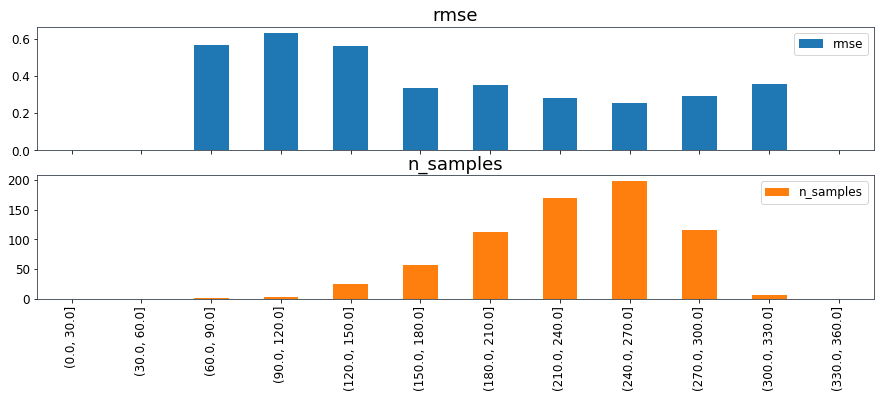

In [22]:
pd.DataFrame({'rmse': bin_rmses, 'n_samples': [stat['n_samples'] for stat in bin_stats.values()]}, 
             index=dir_bins).plot.bar(subplots=True,figsize=(15,5));

- We are getting the highest errors in the bins where we inserted the simple model.
- But, if there is no wind in those bins (= directions), the errors in those bins are not important!
- What we really need is a bin-weighted scoring metric!

### Improved Scoring Metric: Bin-Weighted RMSE

First, we will calculate the weight we give to each bin. This is just proportional to the number of samples in each bin.

In [23]:
bin_n_samples = [stat['n_samples'] for stat in bin_stats.values()]
bin_weights = pd.Series(bin_n_samples, index=dir_bins)/np.sum(bin_n_samples)

Now we can build our scoring function!

In [24]:
def rmse_binned(prediction_spd, reference_spd, reference_dir):
    sqr_errors = (prediction_spd-reference_spd)**2
    weights = bin_weights[reference_dir]
    error = np.sqrt(np.nanmean(sqr_errors.values*weights.values))
    return error

With the scoring function under our belt, let's calculate the bin-weighted RMSE for all of our models' predictions.

In [25]:
all_scores_binned = {}
for model_name, prediction_spd in all_predictions.items():
    data_1D['spd_58'][data_1D['dir_bin'] == dir_bin]
    all_scores_binned[model_name] = rmse_binned(prediction_spd, lt_data_1D['spd'], lt_data_1D['dir'])
    
pd.DataFrame([all_scores, all_scores_binned]).T.rename(columns={0: 'Unweighted', 1: 'Bin-Weighted'})\
    .sort_values('Bin-Weighted').style.bar(vmin=0, vmax=0.5, color='lightblue').format('{:.4f}')

,Unweighted,Bin-Weighted
binned_fill_simple,0.4026,0.1328
binned,0.2888,0.1347
simple,0.3152,0.1416
forest,0.2996,0.1807


The bin-weighted RMSE shows clearer differences between the models than the unweighted score:
- Our binned model that is using the simple model's information to fill in gaps scores best
- Our simple model performs worse than the binned models
- Our forest model performs poorly

**So, after all, we should use our robust binned model to predict long-term wind speeds at our mast!**

### Predicting the Long-Term Wind Speed

Now we can predict the long-term wind speed at our site. This helps us to get a good idea of how much wind energy we can potentially harvest if we build a wind turbine there. 

Remember: We assume the wind in the future will behave like the wind in the past. To get to the long-term wind speed, we take all predictions from our `bin_fill_simple` model. To maximize accuracy, we substitute it with actual measurements from our mast wherever possible.

In [26]:
lt_speed_at_mast = all_predictions['binned_fill_simple']
lt_speed_at_mast[data_1D['spd_58'].index] = data_1D['spd_58']

print('Replaced {} model-predicted samples with measured samples from mast ({:.1%}).'\
      .format(data_1D.shape[0], data_1D.shape[0]/lt_speed_at_mast.shape[0]))

Replaced 761 model-predicted samples with measured samples from mast (10.3%).


Let's summarize our long-term wind speed time series!

In [27]:
print('Start: {:%Y-%m-%d}, Length: {:.0f} years, Avg. spd {:.2f} m/s'\
      .format(lt_speed_at_mast.index[0], lt_speed_at_mast.shape[0]/(365.25), lt_speed_at_mast.mean()))

Start: 1999-12-31, Length: 20 years, Avg. spd 2.86 m/s


**A few words of caution about the long-term wind speed time series**

- Wind speeds usually vary a lot over the day. Therefore, wind turbines produce most energy only within a fraction of that 24 hour period.

- We produced a *daily* time series that does not reflect these wind speed changes during the day, because we averaged hourly wind speeds over that 24 hour period.

- As a result, we will not get realistic energy production numbers with this time series.

- Actual wind resource assessment is much more complicated than shown here.

**From Wind Speed Measurement to Prediction: Takeaways**

- It is easy to build a simple wind speed prediction model
- More advanced models perform not always better
- Domain knowledge can help a lot with finding the right model
- ...and with assessing model performance!

## From Mast Height to Turbine Height

- We have: Long-term wind speed time series at 58 m height (height of the wind speed sensor on the mast)
- We want: Long-term wind speed time series at height of turbine
- We need:
    - Information about turbine height
    - Information about how wind speed behaves with height


In this section: Very short and simplified version.

### Turbine Height

- We arbitrarily choose [Vestas V112](https://en.wind-turbine-models.com/turbines/7-vestas-v112-onshore) as turbine model.
- Hub height: 119 m (hub: "nose" of the turbine around which blades rotate)
- Turbine height: Hub height + elevation of land that turbine stands on (assume 100 m for all turbines)
- Mast height: Mast height + elevation of land that mast stands on (assume 80 m)

<div><img src="./images/sandbox_with_met.jpg" style="width: 20em"></div>

### Shear: Behavior of Wind Speed with Height

We use the [wind profile power law](https://en.wikipedia.org/wiki/Wind_profile_power_law) to scale mast wind speed to turbine height:

$v_{h_\text{turbine}} = v_{h_\text{mast}} \left(\frac{h_\text{turbine}}{h_\text{mast}}\right)^\alpha$

Shear exponent: $\alpha$

Let's find the shear exponent by using [brightwind's](https://github.com/brightwind-dev/brightwind/) `Shear.Average()` method. 

Shear exponent: 0.19


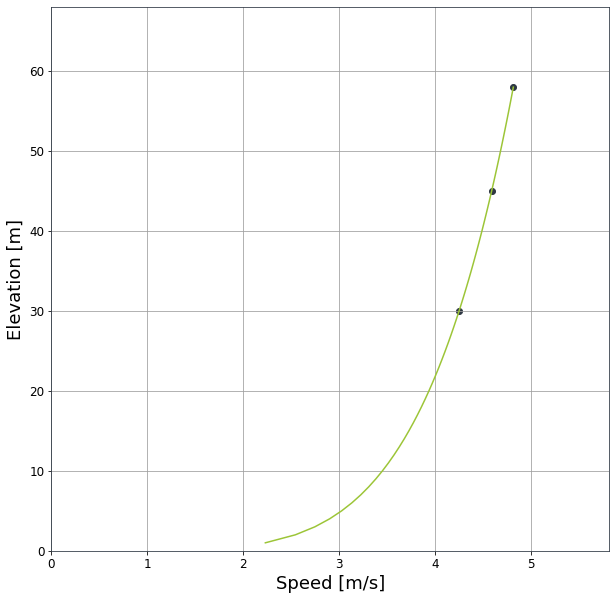

In [28]:
anemometer_heights = [30, 45, 58]
average_shear = bw.Shear.Average(data[anemometers], anemometer_heights)
print('Shear exponent: {:.3}'.format(average_shear.alpha))

### Apply Shear Law to Long-Term Time Series

Now that we know the shear exponent, we can calculate the long-term time series at turbine height.

In [29]:
h_turbine = 100.0 + 119.0
h_mast = 80.0 + 58.0

lt_speed_at_turbine = lt_speed_at_mast*(h_turbine/h_mast)**average_shear.alpha

print('On average, the wind is {:.1%} faster at the turbine height than at the measured height.' \
      .format(lt_speed_at_turbine.mean()/lt_speed_at_mast.mean()-1))

On average, the wind is 9.1% faster at the turbine height than at the measured height.


## Predicting Wind Turbine Power Output

We have come a long way. Now that we have a long-term wind speed time series at turbine height, we are ready to predict turbine power output.



### Power Curve

Power Curve: Turbine power output as function of wind speed. Let's plot the V112 power curve!

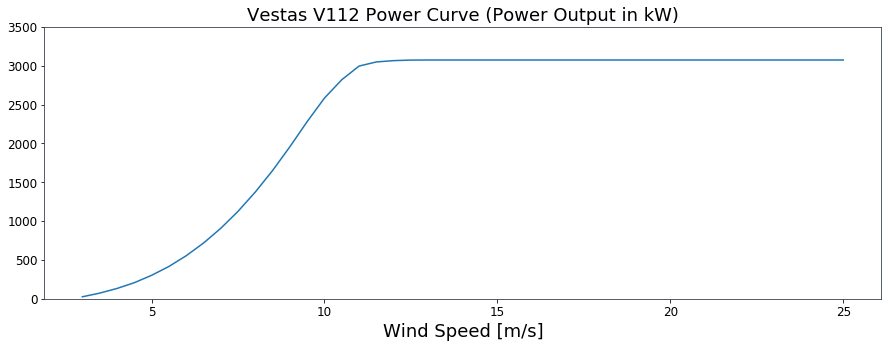

In [30]:
power_curve = pd.read_csv('./data/vestas_v112_power_curve.csv', index_col=0).iloc[:,0]
power_curve.index.name = 'Wind Speed [m/s]'
power_curve.plot(title='Vestas V112 Power Curve (Power Output in kW)', figsize=(15,5), ylim=(0,3500));

Observations: Turbine only starts to produce power at about 2 m/s wind speed, power output is steady between ca. 12 and 25 m/s.

### Power Curve vs. Predicted Wind Speed

Now that we know how much power the V112 turbine produces by wind speed, let's see how our predicted long-term wind speed fits into the picture.

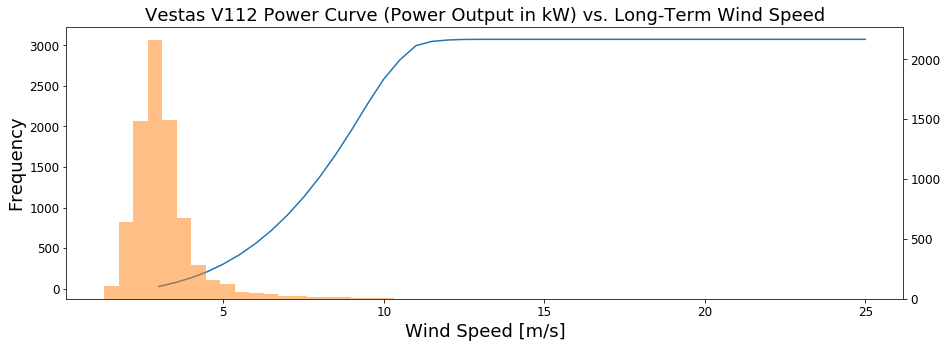

In [53]:
power_curve.plot(title='Vestas V112 Power Curve (Power Output in kW) vs. Long-Term Wind Speed')
lt_speed_at_turbine.plot.hist(secondary_y=True, alpha=0.5, bins=20 , figsize=(15,5), label='long-term');

Observations: Long-term wind speed is very small in comparison to what the turbine can handle, the V112 turbine is completely oversized for this site!

### Calculating Power Output

Despite the V112 being so oversized, let's play around with the energy production numbers we would get if we were to build this turbine. We want to get a "feel" for the power output and put it in the context of the community around the Sandbox, our site.

In [78]:
lt_power_output = np.interp(lt_speed_at_turbine, power_curve.index, power_curve.values, left=0, right=0)
lt_power_output = pd.Series(lt_power_output, index=lt_speed_at_turbine.index)

time_series_duration_years = lt_power_output.shape[0]/(365.25)
output_per_year = lt_power_output.sum()/time_series_duration_years

print('Mean turbine output per year in kWh: {:,.0f}'.format(output_per_year))

Mean turbine output per year in kWh: 24,925


Almost 25 MWh! Is that a lot? Is that a little? Let's express this number in other terms:

In [79]:
print('🍞 Toastable toasts per day for 1 year: {:.0f}'.format(output_per_year/(3.5/60*1.2)/365.25))
print('🚗 Full Tesla Model S charges per year: {:.0f}'.format(output_per_year/100))

🍞 Toastable toasts per day for 1 year: 975
🚗 Full Tesla Model S charges per year: 249


That is a lot of toast and a good amount of electric car charges!

### How Many Households Could We Power?

- 2017: The mean San Diego household consumed 5600 kWh of electricity (source: [SDGE via Equinox Project](https://sites.energycenter.org/equinox/dashboard/residential-electricity-consumption)).
- The Sandbox ZIP code (92121) had 1677 households in 2010 (source: [zip-codes.com](https://www.zip-codes.com/zip-code/92121/zip-code-92121.asp)).

In [97]:
households_per_turbine = output_per_year/5600
pct_of_92121_per_turbine = households_per_turbine/1677

print('With one badly-placed turbine, we could power {:.1f} San Diego households ({:.1%} of all around the Sandbox).'\
      .format(households_per_turbine, pct_of_92121_per_turbine))
print('With 377 badly-placed turbines, we could power {:.0f} San Diego households ({:.1%} of all around the Sandbox).'\
      .format(households_per_turbine*377, pct_of_92121_per_turbine*377))

With one badly-placed turbine, we could power 4.5 San Diego households (0.3% of all around the Sandbox).
With 377 badly-placed turbines, we could power 1678 San Diego households (100.1% of all around the Sandbox).


Well, that looks like a dreadful scenario. But, gladly, our wind measurements are artificial. This means: We don't really know how many turbines it would take to power San Diego households.

Clearly, using just these artificial data, building a wind turbine close to the Sandbox does not make sense.

### Net Capacity Factor (NCF)

Experts measure how well a turbine fits a wind speed distribution and electricity grid environment in terms of net capacity factor (NCF).

This metric describes how much electricity the turbine will generate from the actual wind environment, in comparison to how much it could theoretically generate, if the wind blew enough to make the turbine generate its maximum power output all the time.

In [100]:
ncf = output_per_year/(365.25*power_curve.max())
print('The net capacity factor is {:.1%}.'.format(ncf))

The net capacity factor is 2.2%.


- This net capacity factor is really, really low! (Typical NCFs: 30% - 50%)
- We could place this turbine in way better spots!
- Nobody would build a turbine close to the Sandbox (given our artifical data)!

### How "Valuable" Would our Power be?

- Challenge: Renewable energy is not (always) produced when needed
- Selling energy in high-demand hours can be more profitable vs. in low-demand hours

<span style="color:cornflowerblue">Blue</span>: Demand / <span style="color:coral">Orange</span>: Demand minus solar and wind (Sell energy when this value is high at slightly cheaper prices than fossil fuel power plants to make good profit.)

<a title="ArnoldReinhold / CC BY-SA (https://creativecommons.org/licenses/by-sa/4.0)" href="https://commons.wikimedia.org/wiki/File:Duck_Curve_CA-ISO_2016-10-22.agr.png"><img width="512" alt="Duck Curve CA-ISO 2016-10-22.agr" src="https://upload.wikimedia.org/wikipedia/commons/a/ab/Duck_Curve_CA-ISO_2016-10-22.agr.png"></a>

Let's plot our diurnal profile to see if we would produce a good amount of electricty during these profitable hours.

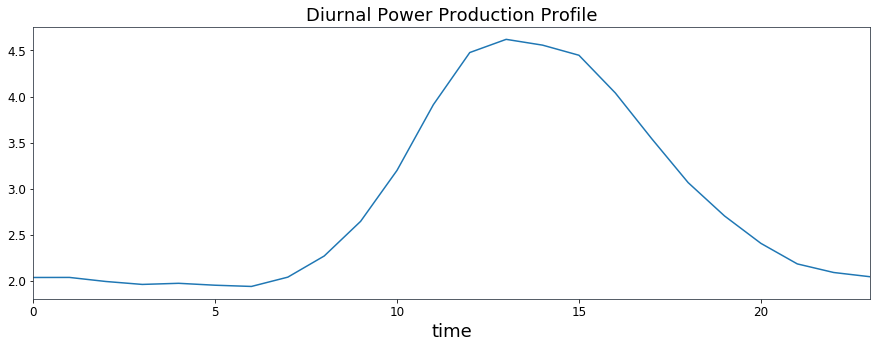

In [108]:
measured_data = data['spd_58'].resample('1h').mean()
measured_data.groupby(measured_data.index.hour).mean()\
    .plot(figsize=(15,5), title='Diurnal Power Production Profile', xlim=(0,23));

Unfortunately, it looks as if we produce power right when a lot of solar power is in the grid, pushing electricity prices down. Not every wind project is like this – sometimes wind speeds are high just as energy demand peaks.

### ...but what would be a good spot for a wind turbine?

Although San Diego not being one of them, there are some good spots for wind turbines in California.

<img src="./images/ca_80m_wind_resource_map.png" style="max-height:20em">


## References
*(unless noted above)*

<small>
    
**Analyzing Wind Data**
- Met data: [synthesizing_a_wind_speed_time_series.ipynb](./data_acquisition/synthesizing_a_wind_speed_time_series.ipynb)

**Getting Wind Data: Met Masts**
- <a href="https://www.flickr.com/photos/75062596@N00/8104180555">"Wind measurement tower, north of Mobridge, South Dakota"</a> by Lars Plougmann is licensed under <a href="https://creativecommons.org/licenses/by-sa/2.0/?ref=ccsearch&atype=html">CC BY-SA 2.0</a>
- <a href="https://www.flickr.com/photos/37467370@N08/7676229992">"Yiwth_3b"</a> by gvgoebel is licensed under <a href="https://creativecommons.org/licenses/by-sa/2.0/?ref=ccsearch&atype=html">CC BY-SA 2.0</a>

**Getting More, Long-Term Data**
- ASOS data: [download_and_preprocess_asos_data.ipynb](./data_acquisition/download_and_preprocess_asos_data.ipynb)

**Topography vs. Wind**
- Fluid animation comes from this video: https://www.youtube.com/watch?v=-GIToNj-m4M
- Elevation map downloaded from here: http://www.sangis.org/download/index.html
    
**Power Curve**
- Vestas V112 Power Curve: [en.wind-turbine-models.com/turbines/7-vestas-v112-onshore](https://en.wind-turbine-models.com/turbines/7-vestas-v112-onshore)
</small>

**References (continued)**

<small>
    
**Calculating Power Output**
- Toaster power consumption: [energyusecalculator.com](http://energyusecalculator.com/electricity_toaster.htm), assumed 1200 W for 3.5 minutes
- Tesla Model S 100 kWh battery: [Wikipedia](https://en.wikipedia.org/w/index.php?title=Tesla_Model_S&oldid=973551445)

**How "Valuable" Would our Power be?**
- Duck curve image from [Wikimedia Commons](https://upload.wikimedia.org/wikipedia/commons/a/ab/Duck_Curve_CA-ISO_2016-10-22.agr.png)

**...but what would be a good spot for a wind turbine?**
- California wind map from [windexchange.energy.gov](https://windexchange.energy.gov/maps-data/12)
</small>